In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image
from numpy import array
from scipy.stats import t, sem, ttest_rel

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [6]:
er = read_csv(join(empo3_dir, 'eval_taxa_er.tsv'), sep='\t')

In [50]:
len(set(er['sample']))

21513

In [38]:
grouped = er.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    errors = x['errors'].sum()
    abundance = x['reads'].sum()
    return Series([errors/abundance], index=['mean'])
figure4 = grouped.apply(weighted_stats)
grouped = figure4.groupby(['class weights', 'level'])
def weighted_stats(x):
    mu = x['mean'].mean()
    se = sem(x['mean'])
    lower, upper = mu-se, mu+se
    return Series([mu, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)
old_labels = [
    'average', 'uniform70', 'bespoke70']
new_labels = [
    'Average', 'Uniform', 'Bespoke']
for old, new in zip(old_labels, new_labels):
    figure4.loc[figure4['class weights'] == old, 'class weights'] = new
figure4['class class'] = figure4['class weights']
figure4.loc[(figure4['class weights'] != 'Average') &
            (figure4['class weights'] != 'Uniform') &
            (figure4['class weights'] != 'Bespoke'),
            'class class'] = 'Other'
figure4 = figure4[figure4['class class'] != 'Other']

In [39]:
figure4

,class weights,level,mean,lower,upper,class class
35,Average,1,0.000078,0.000024,0.000131,Average
36,Average,2,0.008057,0.007023,0.009091,Average
37,Average,3,0.012388,0.010828,0.013947,Average
38,Average,4,0.031006,0.026427,0.035586,Average
39,Average,5,0.052081,0.046633,0.057529,Average
40,Average,6,0.120895,0.111221,0.130569,Average
41,Average,7,0.164737,0.154609,0.174865,Average
42,Bespoke,1,0.000074,0.000024,0.000125,Bespoke
43,Bespoke,2,0.006066,0.004971,0.007160,Bespoke
44,Bespoke,3,0.009927,0.008306,0.011549,Bespoke


In [53]:
%%R -i figure4

figure4$class.weights = factor(figure4$class.weights, levels=c(
    'Average', 'Uniform', 'Bespoke'
))

cbPalette <- c("#56B4E9", "#009E73", "#E69F00")
ggplot(figure4, aes(x=level, y=mean*100, 
                    colour=class.weights,
                    fill=class.weights)) + 
geom_col(data=figure4[figure4$class.weights == 'Uniform',]) + 
geom_col(data=figure4[figure4$class.weights == 'Average',]) + 
geom_col(data=figure4[figure4$class.weights == 'Bespoke',]) +
geom_errorbar(aes(ymin=lower*100, ymax=upper*100),
              width=0.4, colour='black', alpha=0.5) +
theme_bw() +
  labs(y='Error Rate (%)', x='Taxonomy Level') +
  scale_colour_manual(name='Taxonomic Weights', values=cbPalette) +
  scale_fill_manual(name='Taxonomic Weights', values=cbPalette) +
  scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c('Kingdom',
                 'Phylum',
                 'Class',
                 'Order',
                 'Family',
                 'Genus',
                 'Species')) + 
theme(axis.text.x = element_text(angle = 30, vjust=1, hjust=1))

ggsave(file="3d-plot.png", width=5, height=5, dpi=300)

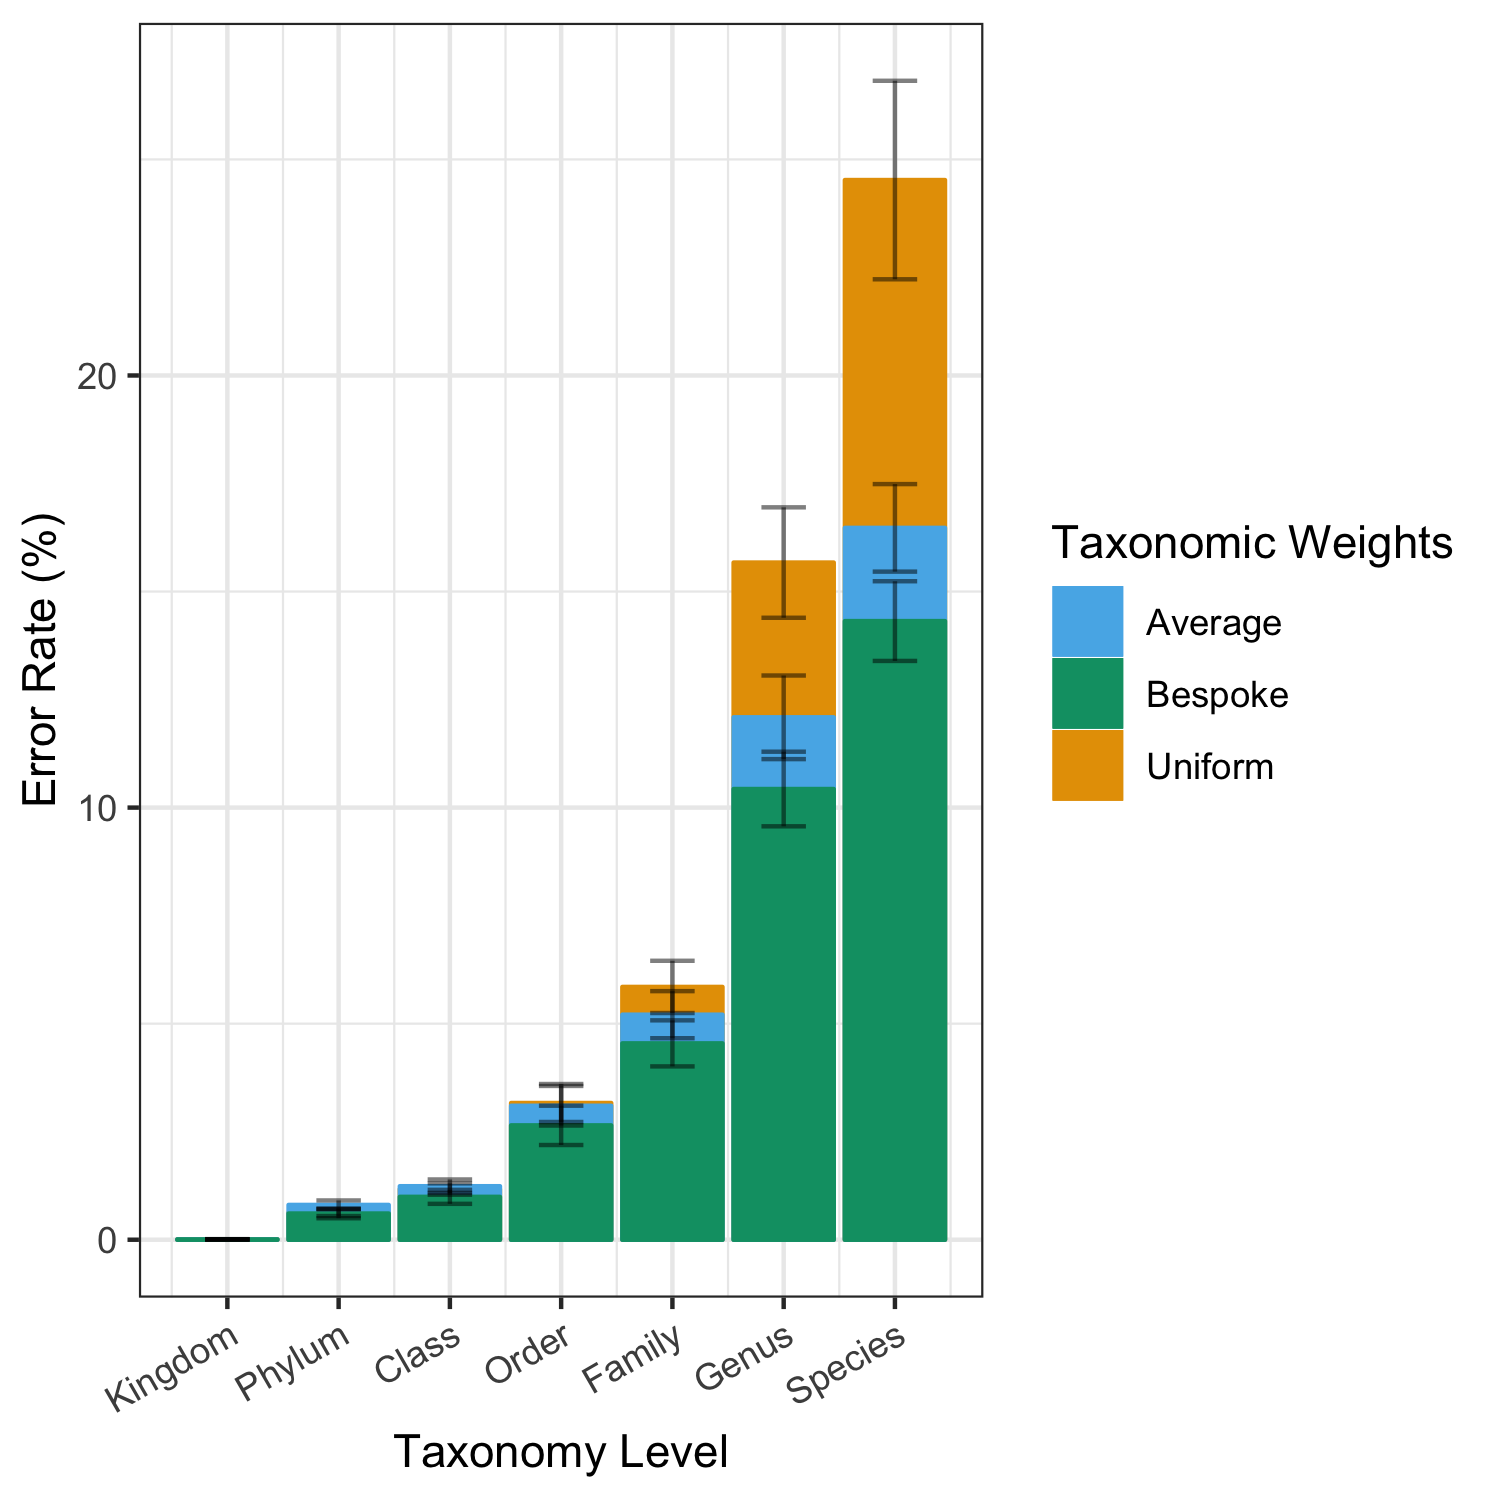

In [54]:
Image("3d-plot.png")

In [9]:
uniform = figure4[figure4['class class'] == 'Uniform']
print(uniform[uniform['level'] == 3]['mean'].mean())
print(sem(uniform[uniform['level'] == 3]['mean']))
print(uniform[uniform['level'] == 6]['mean'].mean())
print(sem(uniform[uniform['level'] == 6]['mean']))
print(uniform[uniform['level'] == 7]['mean'].mean())
print(sem(uniform[uniform['level'] == 7]['mean']))

0.991553154727
0.000971514001841
0.879831509346
0.0105850379277
0.810874207902
0.0172711967093


In [10]:
ttest_rel(array(uniform[uniform['level'] == 6]['mean']) - uniform[uniform['level'] == 3]['mean'],
          array(uniform[uniform['level'] == 7]['mean']) - uniform[uniform['level'] == 6]['mean'])

Ttest_relResult(statistic=-1.8744720123799761, pvalue=0.083510093048044395)

In [11]:
(array(array(uniform[uniform['level'] == 6]['mean']) - uniform[uniform['level'] == 4]['mean']) -
          (array(uniform[uniform['level'] == 7]['mean']) - uniform[uniform['level'] == 6]['mean'])).mean()

-0.028886436220853746

In [12]:
bespoke = figure4[figure4['class class'] == 'Bespoke']
ttest_rel(array(uniform[uniform['level'] == 7]['mean']),
          array(bespoke[bespoke['level'] == 7]['mean']))

Ttest_relResult(statistic=-5.8334669588962491, pvalue=5.8426367911984738e-05)

In [13]:
print(bespoke[bespoke['level'] == 3]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 3]['mean']))
print(bespoke[bespoke['level'] == 6]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 6]['mean']))
print(bespoke[bespoke['level'] == 7]['mean'].mean())
print(sem(bespoke[bespoke['level'] == 7]['mean']))

0.991935437912
0.00133727344883
0.918377777295
0.00683309042099
0.886993724265
0.00758096644029
